<center><h1>HSE FCS SE ML</h1></center>
<center><h1>"Fast sold post prediction" Kaggle competition</h1></center>
<center><h2>Team name: Turbo 3D</h2></center>
<center><h3>Daniil Kraynov, Dmitry Strokov, Danil Kolesnikov</h3></center>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

GPU_USED = False
CROSS_VAL_NEEDED = False

In [2]:
def plot_bars(labels, values):
    plt.figure(figsize=(15, 10))
    y_pos = np.arange(len(labels[:20]))
    plt.barh(y_pos, values[:20][::-1])
    plt.yticks(y_pos, labels[:20][::-1])
    plt.show()

def make_bars(fts):
    labels = [x[0] for x in fts]
    values = [x[1] for x in fts]
    plot_bars(labels, values)

# Read Data

In [4]:
df = pd.read_csv('./data/train.tsv.gz', sep='\t').drop(columns='Unnamed: 0')

In [5]:
df.head()

,category_id,city,date_created,delivery_available,desc_text,img_num,lat,long,name_text,owner_id,payment_available,price,product_id,product_type,properties,region,sold_mode,subcategory_id,sold_fast
0,4,Краснодар,2018-10-08,False,"Продаю стол раскладной, деревянный, советский ...",3,45.0686,38.9518,Стол,4ce583fe8231a0cc4a3c7d241c7d0289,True,500.0,8cb80c05c65c210275f5500779d6b593,1,"[{'slug_id': 'stoly_stulya_tip', 'slug_name': ...",Краснодарский край,1,410,1
1,4,Тюмень,2018-06-18,False,"Тарелки глубокие 6 шт. Блюдца, чашки по 6 шт. ...",2,57.1840,65.5674,Посуда,e58be2c8f143c17246dc2243b5d3b98f,False,300.0,3b7a9f8b27a53b63525f95bc8070abb2,1,"[{'slug_id': 'dom_dacha_posuda_tip', 'slug_nam...",Тюменская область,1,405,0
2,9,Омск,2018-07-31,True,"Новый,с этикеткой. Размер L. Не подошёл по раз...",1,54.9889,73.4312,Костюм,51b408796027214232532b7e478e2159,True,1100.0,c97dd9c5a3e938c52cf5d7822bc0eb7b,1,[{'slug_id': 'zhenskaya_odezhda_pidzhaki_kosty...,Омская область,1,908,0
3,3,Санкт-Петербург,2018-04-17,False,"Складывается тростью, все колеса вниз. Сплошна...",4,59.9590,30.4877,Коляска,6544b83acbbf04439a7ba983093cafb4,True,5000.0,3e5d0286b25fd7f62f88bc436a59ae4e,1,"[{'slug_id': 'waggon_type', 'slug_name': 'Тип'...",Ленинградская область,1,312,0
4,5,Москва,2018-02-09,False,"Неразлучники, птичкам по 1,5 года. Продаю с бо...",2,55.6473,37.4118,Волнистые попугаи,ea575e28daf1f47bfce63015cd3ce5cf,True,2000.0,57b4a8679d0d3eb1e31367b57221098f,1,[],Московская область,1,504,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351281 entries, 0 to 351280
Data columns (total 19 columns):
category_id           351281 non-null int64
city                  351281 non-null object
date_created          351281 non-null object
delivery_available    351281 non-null bool
desc_text             351281 non-null object
img_num               351281 non-null int64
lat                   351281 non-null float64
long                  351281 non-null float64
name_text             351281 non-null object
owner_id              351281 non-null object
payment_available     351281 non-null bool
price                 351281 non-null float64
product_id            351281 non-null object
product_type          351281 non-null int64
properties            351281 non-null object
region                351281 non-null object
sold_mode             351281 non-null int64
subcategory_id        351281 non-null int64
sold_fast             351281 non-null int64
dtypes: bool(2), float64(3), int64(6), ob

# Preprocessing "properties" feature

The interesting JSON field we have is "properties".

As you can see below, we had a lot of fun with parsing it.

We figured out, that, basically, "properties" is an array of objects, each of them has the key (slug_id) and the value (value_id). Usually it represents some category in market. The number of the unique keys was not very large, so we decided to create column for each (later we will select the most important categories).

In [7]:
import json

def parse_properties(jstr_orig):
    jstr = jstr_orig
    jstr = jstr.replace("\"Cee'd\"", "'_'")
    jstr = jstr.replace("\\xa0", "_")
    jstr = jstr.replace("\"Levi's\"", "'_'")
    jstr = jstr.replace("\"Victoria's Secret\"", "'_'")
    jstr = jstr.replace("\"O'Stin\"", "'_'")
    jstr = jstr.replace("\"Carter's\"", "'_'")
    jstr = jstr.replace("\"Colin's\"", "'_'")
    jstr = jstr.replace('"', '!@#$').replace("'", '"').replace('!@#$', "'")
    try:
        obj = json.loads(jstr)
        return obj
    except:
        print(jstr)
    return json.loads(jstr)

min_usage = 50

def preprocess_properties(df_source):
    s = df_source.drop(columns=['properties'])
    
    props_col = df_source['properties'].apply(parse_properties)
    
    all_props = dict()
    for props in props_col.values:
        for prop in props:
            prop_name = "slug_" + prop['slug_id'] 
            if prop_name not in all_props:
                all_props[prop_name] = 0
            all_props[prop_name] += 1
    
    for i in range(len(s)):
        if i % 20000 == 0:
            print("Done: {:.2f}%".format(i / len(s) * 100))
        for prop in props_col.values[i]:
            prop_name = "slug_" + prop['slug_id']
            if all_props[prop_name] < min_usage:
                continue
            if prop_name not in s.columns:
                s[prop_name] = -1
            s.at[i, prop_name] = prop["value_id"]
    return s

In [8]:
df2 = preprocess_properties(df)

Done: 0.00%
Done: 5.69%
Done: 11.39%
Done: 17.08%
Done: 22.77%
Done: 28.47%
Done: 34.16%
Done: 39.85%
Done: 45.55%
Done: 51.24%
Done: 56.93%
Done: 62.63%
Done: 68.32%
Done: 74.01%
Done: 79.71%
Done: 85.40%
Done: 91.10%
Done: 96.79%


In [9]:
df2.head()

,category_id,city,date_created,delivery_available,desc_text,img_num,lat,long,name_text,owner_id,...,slug_videokamery_opticheskiy_zoom,slug_mikrofony_tip_pudklucheniya,slug_spectekhnika_tip,slug_zaryadnye_ustrojstva_razjom_podklucheniya,slug_zaryadnye_ustrojstva_vihodnaya_sila_toka,slug_zaryadnye_ustrojstva_nalichie_kabelya,slug_stacionarnye_telefony_tip,slug_stacionarnye_telefony_avtootvetchik,slug_stacionarnye_aon,slug_vytyazhki_marka
0,4,Краснодар,2018-10-08,False,"Продаю стол раскладной, деревянный, советский ...",3,45.0686,38.9518,Стол,4ce583fe8231a0cc4a3c7d241c7d0289,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,4,Тюмень,2018-06-18,False,"Тарелки глубокие 6 шт. Блюдца, чашки по 6 шт. ...",2,57.1840,65.5674,Посуда,e58be2c8f143c17246dc2243b5d3b98f,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,9,Омск,2018-07-31,True,"Новый,с этикеткой. Размер L. Не подошёл по раз...",1,54.9889,73.4312,Костюм,51b408796027214232532b7e478e2159,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,3,Санкт-Петербург,2018-04-17,False,"Складывается тростью, все колеса вниз. Сплошна...",4,59.9590,30.4877,Коляска,6544b83acbbf04439a7ba983093cafb4,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,5,Москва,2018-02-09,False,"Неразлучники, птичкам по 1,5 года. Продаю с бо...",2,55.6473,37.4118,Волнистые попугаи,ea575e28daf1f47bfce63015cd3ce5cf,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351281 entries, 0 to 351280
Columns: 417 entries, category_id to slug_vytyazhki_marka
dtypes: bool(2), float64(3), int64(405), object(7)
memory usage: 1.1+ GB


Occurrences:


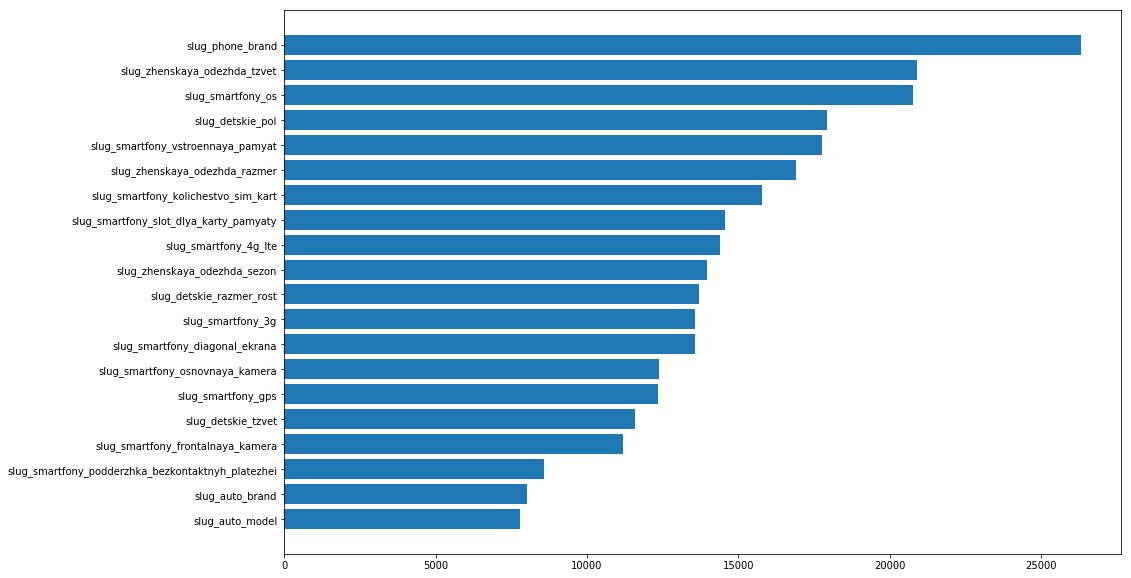

In [11]:
slug_features = []

for feature in df2.columns:
    if 'slug_' in feature:
        col = df2[feature].values
        slug_features.append([feature, len(col[col != -1])])

print("Occurrences:")
slug_features.sort(key=lambda x: x[1], reverse=True)
make_bars(slug_features)

# Preprocessing text features

As we have 2 text features, we can simply process it through the TfidfVectorizer. We don't want the number of new columns to be large, so we will manually limit the number of tokens to produce.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

def preprocess_text(df_source):
    s = df_source.drop(columns=['desc_text', 'name_text'])
    
    vectorizer = TfidfVectorizer(max_features=130)
    desc_vec = vectorizer.fit_transform(df_source['desc_text'].values).toarray()
    desc_features = ["desc_text_" + name for name in vectorizer.get_feature_names()]
    desc_df = pd.DataFrame(desc_vec, columns=desc_features)
    s = s.join(desc_df)
    s['desc_text_len'] = df_source['desc_text'].apply(len)
    
    vectorizer = TfidfVectorizer(max_features=70)
    name_vec = vectorizer.fit_transform(df_source['name_text'].values).toarray()
    name_features = ["name_text_" + name for name in vectorizer.get_feature_names()]
    name_df = pd.DataFrame(name_vec, columns=name_features)
    s = s.join(name_df)
    s['name_text_len'] = df_source['name_text'].apply(len)
    
    return s

In [13]:
df2 = preprocess_text(df2)

In [14]:
df2.head()

,category_id,city,date_created,delivery_available,img_num,lat,long,owner_id,payment_available,price,...,name_text_стиральная,name_text_стол,name_text_сумка,name_text_телевизор,name_text_телефон,name_text_туфли,name_text_холодильник,name_text_шины,name_text_шкаф,name_text_len
0,4,Краснодар,2018-10-08,False,3,45.0686,38.9518,4ce583fe8231a0cc4a3c7d241c7d0289,True,500.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
1,4,Тюмень,2018-06-18,False,2,57.1840,65.5674,e58be2c8f143c17246dc2243b5d3b98f,False,300.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
2,9,Омск,2018-07-31,True,1,54.9889,73.4312,51b408796027214232532b7e478e2159,True,1100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
3,3,Санкт-Петербург,2018-04-17,False,4,59.9590,30.4877,6544b83acbbf04439a7ba983093cafb4,True,5000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
4,5,Москва,2018-02-09,False,2,55.6473,37.4118,ea575e28daf1f47bfce63015cd3ce5cf,True,2000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17


In [15]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351281 entries, 0 to 351280
Columns: 617 entries, category_id to name_text_len
dtypes: bool(2), float64(203), int64(407), object(5)
memory usage: 1.6+ GB


Occurances:


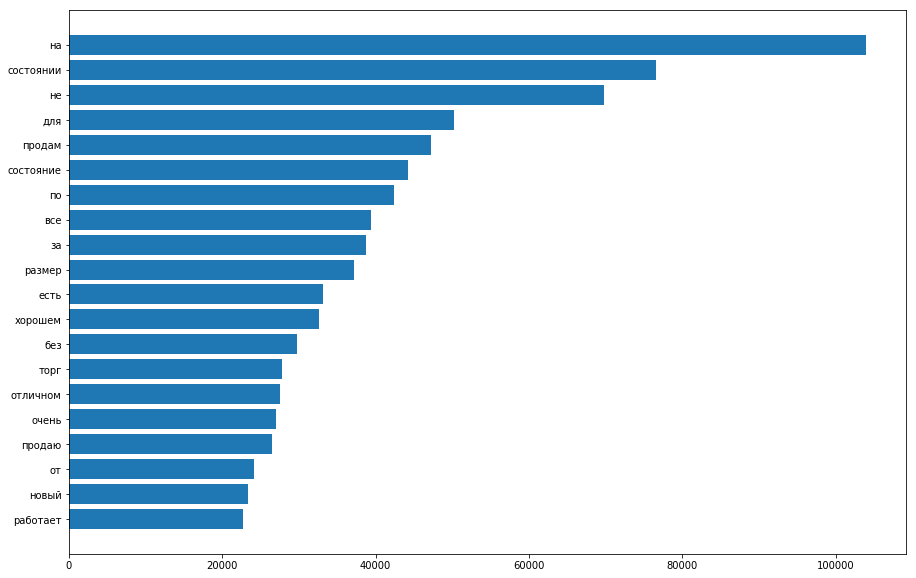

In [16]:
text_features = []

for feature in df2.columns:
    if 'desc_text_' not in feature and 'name_text_' not in feature:
        continue
    if feature in ['desc_text_len', 'name_text_len']:
        continue
    col = df2[feature].values
    text_features.append([feature[10:], len(col[col > 0])])

print("Occurances:")
text_features.sort(key=lambda x: x[1], reverse=True)
make_bars(text_features)

# Study/preprocess categorical features

First of all, we need to understand what categories are important before applying one-hot encoding to categorical features.

We assume that category importancy depends on usage (number of entries) and sold probability.

In [17]:
def get_category_sold_probability(df_source, column, value):
    target_col = df_source['sold_fast'].values
    target_col_in_category = target_col[column == value]
    target_col_in_category_sold = target_col_in_category[target_col_in_category == 1]
    return len(target_col_in_category_sold) / len(target_col_in_category)

In [18]:
# Let's consider magnitude as abs(sold_probability - 0.5)
def get_category_magnitude(df_source, column, value):
    return abs(get_category_sold_probability(df_source, column, value) - 0.5)

In [19]:
all_categories = []

min_usage = 50

except_columns = ['date_created', 'delivery_available', 'payment_available',
                  'img_num', 'lat', 'long', 'price', 'product_id', 'sold_fast']

for i in range(len(df2.columns)):
    feature_name = df2.columns[i]
    if feature_name in except_columns or 'desc_text' in feature_name or 'name_text' in feature_name:
        print("\rSkipping", feature_name, "[", i + 1, "of", len(df2.columns), "]", " " * 100, end='')
        continue
    print("\rScanning", feature_name, "[", i + 1, "of", len(df2.columns), "]", " " * 100, end='')
    column = df2[feature_name].values
    categories, usages = np.unique(column, return_counts=True)
    for i in range(len(categories)):
        usage = usages[i]
        if usage < min_usage:
            continue
        category = categories[i]
        if "slug" in feature_name and category == -1:
            continue
        info = [feature_name, category]
        info.append(usage)
        info.append("{:.3f}%".format(usage / len(column) * 100))
        info.append(get_category_magnitude(df2, column, category))
        all_categories.append(info)

Skipping name_text_len [ 617 of 617 ]                                                                                                                                          slug_smartfony_tip [ 364 of 617 ]                                                                                                     

In [20]:
len(all_categories)

2418

In [21]:
selected_categories = set()

def select_top_categories(from_cat, n_select):
    global selected_categories
    top_features = from_cat['feature'].values[:n_select]
    top_categories = from_cat['category'].values[:n_select]
    selected_categories |= set(zip(top_features, top_categories))

In [22]:
cat_df = pd.DataFrame(
    np.array(all_categories),
    columns=['feature', 'category', 'usage', 'usage%', 'magnitude']
)
for col_name in ['usage', 'magnitude']:
    cat_df[col_name] = pd.to_numeric(cat_df[col_name])
cat_df.head()

,feature,category,usage,usage%,magnitude
0,category_id,1,20702,5.893%,0.295817
1,category_id,2,15883,4.521%,0.171662
2,category_id,3,39089,11.128%,0.262184
3,category_id,4,29676,8.448%,0.241171
4,category_id,5,15864,4.516%,0.261599


Let's select some categories with highest magnitude

Top categories by magnitude:


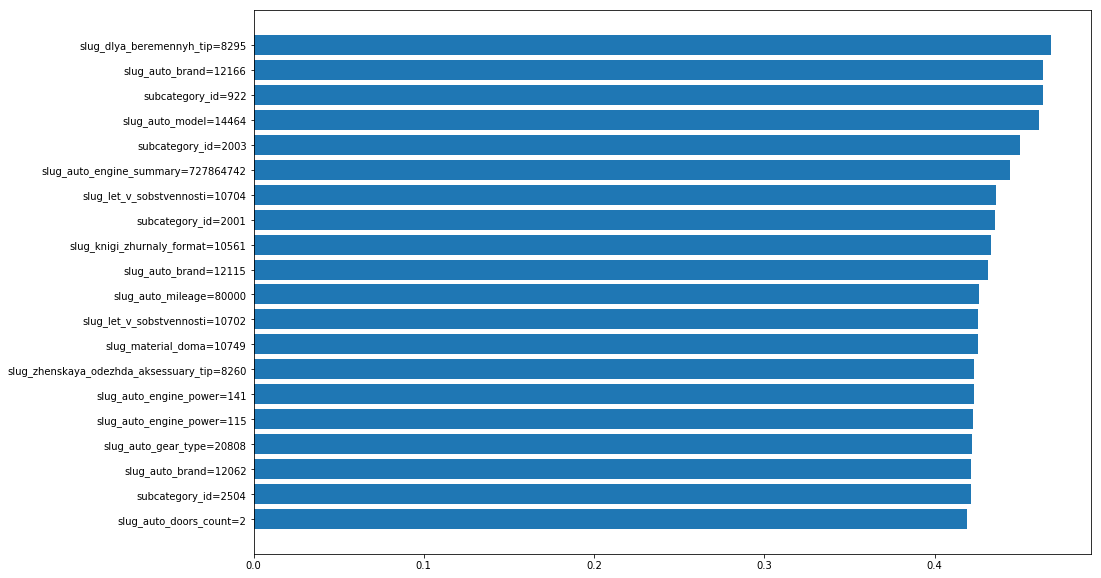

,feature,category,usage,usage%,magnitude
2163,slug_dlya_beremennyh_tip,8295,63,0.018%,0.468254
1353,slug_auto_brand,12166,55,0.016%,0.463636
688,subcategory_id,922,55,0.016%,0.463636
1485,slug_auto_model,14464,52,0.015%,0.461538
783,subcategory_id,2003,100,0.028%,0.450000
1587,slug_auto_engine_summary,727864742,54,0.015%,0.444444
2005,slug_let_v_sobstvennosti,10704,438,0.125%,0.436073
781,subcategory_id,2001,790,0.225%,0.435443
2050,slug_knigi_zhurnaly_format,10561,60,0.017%,0.433333
1349,slug_auto_brand,12115,73,0.021%,0.431507


In [23]:
cat_df_by_magnitude = cat_df.sort_values(by=['magnitude'], ascending=False)
for_bars = []
for i in range(20):
    label = cat_df_by_magnitude['feature'].values[i]
    label += "="
    label += cat_df_by_magnitude['category'].values[i]
    value = cat_df_by_magnitude['magnitude'].values[i]
    for_bars.append([label, value])
print("Top categories by magnitude:")
make_bars(for_bars)
cat_df_by_magnitude.head(10)

In [24]:
select_top_categories(cat_df_by_magnitude, 100)

And also some categories with highest usage

Top categories by usage:


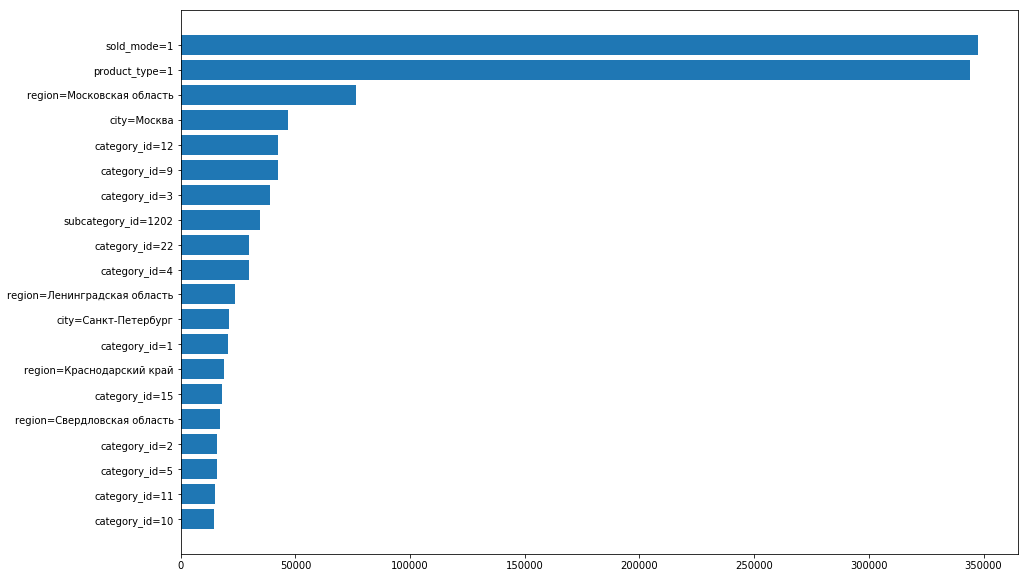

,feature,category,usage,usage%,magnitude
571,sold_mode,1,347511,98.927%,0.269702
490,product_type,1,344224,97.991%,0.267709
526,region,Московская область,76281,21.715%,0.272316
276,city,Москва,46973,13.372%,0.269527
11,category_id,12,42589,12.124%,0.206661
8,category_id,9,42390,12.067%,0.337603
2,category_id,3,39089,11.128%,0.262184
715,subcategory_id,1202,34762,9.896%,0.193545
19,category_id,22,29811,8.486%,0.330130
3,category_id,4,29676,8.448%,0.241171


In [25]:
cat_df_by_usage = cat_df.sort_values(by=['usage'], ascending=False)
for_bars = []
for i in range(20):
    label = cat_df_by_usage['feature'].values[i]
    label += "="
    label += cat_df_by_usage['category'].values[i]
    value = cat_df_by_usage['usage'].values[i]
    for_bars.append([label, value])
print("Top categories by usage:")
make_bars(for_bars)
cat_df_by_usage.head(10)

In [26]:
select_top_categories(cat_df_by_usage, 100)

In [27]:
selected_categories

{('category_id', '1'),
 ('category_id', '10'),
 ('category_id', '11'),
 ('category_id', '12'),
 ('category_id', '13'),
 ('category_id', '14'),
 ('category_id', '15'),
 ('category_id', '2'),
 ('category_id', '20'),
 ('category_id', '22'),
 ('category_id', '23'),
 ('category_id', '3'),
 ('category_id', '4'),
 ('category_id', '5'),
 ('category_id', '6'),
 ('category_id', '8'),
 ('category_id', '9'),
 ('city', 'Екатеринбург'),
 ('city', 'Казань'),
 ('city', 'Краснодар'),
 ('city', 'Красноярск'),
 ('city', 'Москва'),
 ('city', 'Новосибирск'),
 ('city', 'Пермь'),
 ('city', 'Приморско-Ахтарск'),
 ('city', 'Ростов-на-Дону'),
 ('city', 'Санкт-Петербург'),
 ('city', 'Тюмень'),
 ('city', 'Уфа'),
 ('city', 'Челябинск'),
 ('product_type', '1'),
 ('product_type', '5'),
 ('region', 'Алтайский край'),
 ('region', 'Башкортостан'),
 ('region', 'Иркутская область'),
 ('region', 'Кемеровская область'),
 ('region', 'Краснодарский край'),
 ('region', 'Красноярский край'),
 ('region', 'Ленинградская область'

# Encode Data

Now, for ML algorithms, we want to have all the data in numeric format, let's apply LabelEncoding and OneHotEncoding for selected features.

In [124]:
from sklearn.preprocessing import LabelEncoder

import time
import datetime

# Encode data to numberic format
# Drop excess columns
# Apply one hot encoding
def encode_data(df_source):
    lb = LabelEncoder()
    
    columns_to_drop = ['product_id']
    for col_name in df_source.columns:
        if 'slug' in col_name:
            columns_to_drop.append(col_name)
    
    s = df_source.drop(columns=columns_to_drop)

    # Delivery/payment encoding: 0 is false (bad), 1 is true (good)
    s['delivery_available'] = lb.fit_transform(s['delivery_available'])
    s['payment_available'] = lb.fit_transform(s['payment_available'])
    # City/region encoding
    s['city'] = lb.fit_transform(s['city'])
    s['region'] = lb.fit_transform(s['region'])
    # Converting date to timestamp
    dates = s['date_created'].values
    convert_time = lambda d: int(time.mktime(datetime.datetime.strptime(d, "%Y-%m-%d").timetuple()))
    s['date_created'] = list(map(convert_time, dates))
    # Misc
    s['owner_id'] = lb.fit_transform(s['owner_id'])
    
    for feature, category in selected_categories:
        fcol = df_source[feature].apply(str).values
        ncol = np.zeros(len(fcol), dtype='int64')
        ncol[fcol == category] = 1
        s['{}={}'.format(feature, category)] = ncol
    
    return s

In [125]:
df_encoded = encode_data(df2)

In [126]:
df_encoded.head()

,category_id,city,date_created,delivery_available,img_num,lat,long,owner_id,payment_available,price,...,category_id=12,category_id=2,category_id=22,subcategory_id=317,slug_auto_engine_power=120,city=Казань,subcategory_id=1202,slug_sputnikovoe_i_tsifrovoe_tv_tip=9822,slug_detskaya_odezhda_aksessuary_tip=10834,region=Ленинградская область
0,4,941,1538946000,0,3,45.0686,38.9518,91874,1,500.0,...,0,0,0,0,0,0,0,0,0,0
1,4,2025,1529269200,0,2,57.1840,65.5674,273737,0,300.0,...,0,0,0,0,0,0,0,0,0,0
2,9,1444,1532984400,1,1,54.9889,73.4312,97532,1,1100.0,...,0,0,0,0,0,0,0,0,0,0
3,3,1703,1523912400,0,4,59.9590,30.4877,120916,1,5000.0,...,0,0,0,0,0,0,0,0,0,1
4,5,1222,1518123600,0,2,55.6473,37.4118,279555,1,2000.0,...,0,0,0,0,0,0,0,0,0,0


In [127]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351281 entries, 0 to 351280
Columns: 417 entries, category_id to region=Ленинградская область
dtypes: float64(203), int64(214)
memory usage: 1.1 GB


# Split data

In [128]:
X = df_encoded.drop(columns=['sold_fast'])
y = df_encoded['sold_fast']

# Fitting & Predicting

In this competition, we decided to use xgboost algorithm as it has proved its incredible power all around the world.

In [ ]:
# To avoid kernel dying
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier
import xgboost as xgb

We launched cross-validation with early stopping many times, before we found the best hyperparameters (you can see them below), and achieved our best internal CV auc score 0.639196.

First of all, colsample_bytree was set to 0.3 beacause of large amount of columns. We tried to increment it multiple times, but it didn't give any positive results.

max_depth = 6 was found experimentally by iterating over [3, 4, 5, 6, 7, 8] options.

Finally, we set learning_rate to very low value (0.01) and cross validation algorithm didn't found any auc decrease in 50 closest boosting rounds even after 5000 boosting rounds totally. That's why we decided to use 5000 estimators in our config.

In [ ]:
xgb_params = {
    'objective': 'binary:logistic',
    'gamma': 0,
    'learning_rate': 0.01,
    'n_estimators': 5000, # Set best before real fit/predict!!!
    'max_depth': 6,
    'seed': 27,
    'silent': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.3,
    'n_jobs': 4,
    'predictor':'cpu_predictor'
}

if GPU_USED:
    xgb_params['tree_method'] = 'gpu_hist'

In [ ]:
if CROSS_VAL_NEEDED:
    model = XGBClassifier(**xgb_params)
    #0.639196
    xgb.cv(
        model.get_xgb_params(),
        xgb.DMatrix(X, label=y),
        num_boost_round=xgb_params['n_estimators'],
        nfold=5,
        metrics='auc',
        early_stopping_rounds=50,
        verbose_eval=True)

# Metrics

Here we will use a little bit simplified model parameters just to plot the ROC AUC and feature importance in predicting.

In [129]:
xgb_params_simplified = {
    'objective': 'binary:logistic',
    'gamma': 0,
    'learning_rate': 0.1,
    'n_estimators': 700,
    'max_depth': 6,
    'seed': 27,
    'silent': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.3,
    'n_jobs': 4,
    'predictor':'cpu_predictor'
}

In [130]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [131]:
model = XGBClassifier(**xgb_params_simplified)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=700,
       n_jobs=4, nthread=None, objective='binary:logistic',
       predictor='cpu_predictor', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=1, subsample=0.8)

In [139]:
from sklearn.metrics import roc_auc_score

y_proba = model.predict_proba(X_test)[:,1]

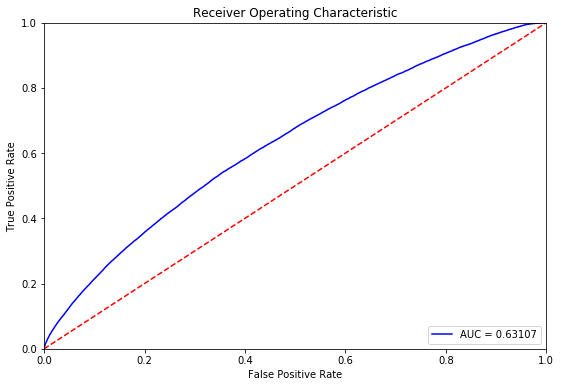

In [140]:
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(y_test, y_proba)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(9, 6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Feature importance:


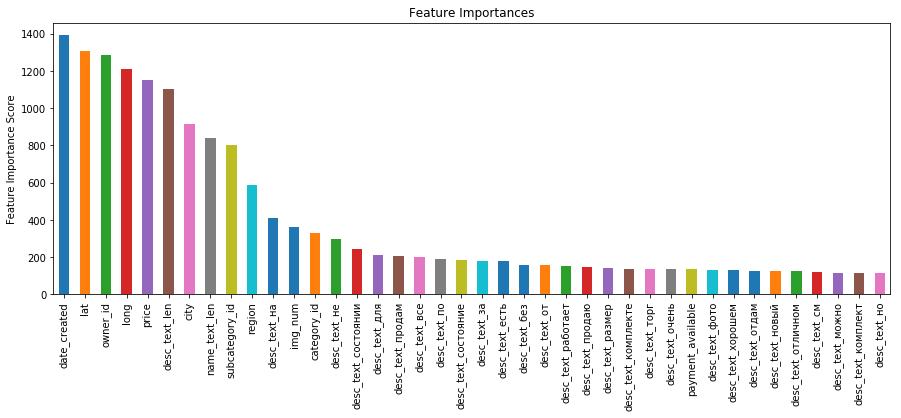

In [152]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 5
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)[:40]
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
print("Feature importance:")

# Test Data Prediction

All we have left is to predict the test data and submit it.

In [ ]:
df2, df_encoded, all_categories = None, None, None

In [ ]:
df_test = pd.read_csv('test_nolabel.tsv', sep='\t').drop(columns='Unnamed: 0')
df_test["sold_fast"] = 0
df_merged = pd.concat([df, df_test])
df_merged.reset_index(inplace=True, drop=True)

In [ ]:
df_merged_p = encode_data(preprocess_text(preprocess_properties(df_merged)))
df_mp = df_merged_p[:len(df)]
df_test_mp = df_merged_p[len(df):]

In [ ]:
X_fit = df_mp.drop(columns=['sold_fast'])
y_fit = df_mp['sold_fast']
X_actual = df_test_mp.drop(columns=['sold_fast'])

In [ ]:
model = XGBClassifier(**xgb_params)
model.fit(X_fit, y_fit)

In [ ]:
import joblib
joblib.dump(model, 'model.dat')

In [ ]:
y_actual = model.predict_proba(X_actual)[:, 1]
y_actual

In [ ]:
df_final = pd.DataFrame.from_dict({'product_id' : df_test['product_id'].values, 'score' : y_actual})
df_final.to_csv('submission.csv', sep = ',', index = False)

# Summary

1. 'properties' json feature was parsed and new columns were generated for each slug type.
2. Text token columns were generated for desc_text and name_text by TFIDF algorithm.
3. All categories for each categorical feature were generated, filtered by usage and sold probability and then new columns were added using one-hot encoding.
4. Label encoding was applied for non-numerical categorical features.
5. XGBoostClassifier was tuned using CV and early-stopping methods.
6. Final model was trained on whole data and then predicted target value and preliminary ROC AUC score 0.62293 was achieved in Kaggle.

Sincerely yours, Turbo 3D